In [1]:
import sys
import os

# Add the parent directory (X) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import wandb
import matplotlib.pyplot as plt

import climex_utils as cu
import trainmodel as tm
import networks as nw


if __name__ == "__main__":

    # Importing all required arguments
    args = tm.get_args()

    # Initializing WandB
    if args.wandb:
        wandb.init(project="prob-unet-mds", config=args)

    # Initializing the UNet model
    unet_model = nw.UNet(img_resolution=args.resolution, in_channels=len(args.variables), out_channels=len(args.variables), label_dim=0, use_diffuse=False)
    unet_model.to(args.device)
    if args.wandb:
        wandb.watch(models=unet_model)

    # Initiliazing the training and testing dataset
    dataset_train = cu.climex2torch(args.datadir, years=args.years_train, coords=args.coords, lowres_scale=args.lowres_scale, train=True)
    dataset_val = cu.climex2torch(args.datadir, years=args.years_val, coords=args.coords, lowres_scale=args.lowres_scale, train=False, trainset=dataset_train)
    dataset_test = cu.climex2torch(args.datadir, years=args.years_test, coords=args.coords, lowres_scale=args.lowres_scale, train=False, trainset=dataset_train)

    # Initiliazing the dataloaders
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=4)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False, num_workers=4)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, num_workers=4)
    dataloader_test_random = torch.utils.data.DataLoader(dataset_test, batch_size=args.batch_size, shuffle=True, num_workers=4)

    # Initiliazing training objects
    scaler = torch.cuda.amp.GradScaler()
    optimizer = args.optimizer(params=unet_model.parameters(), lr=args.lr)
    loss_fn = torch.nn.MSELoss()

    tr_losses = []
    val_losses = []
    # Looping over all epochs
    for epoch in range(1, args.num_epochs+1):

        # Training for one epoch (going over all training data)
        epoch_tr_loss = tm.train_step(model=unet_model, dataloader=dataloader_train, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler, epoch=epoch, num_epochs=args.num_epochs, accum=args.accum, wandb=args.wandb, device=args.device)
        tr_losses.append(epoch_tr_loss)

        # Evaluating the model on testing data
        epoch_val_loss = tm.eval_model(model=unet_model, dataloader=dataloader_test, loss_fn=loss_fn, wandb=args.wandb, device=args.device)
        val_losses.append(epoch_val_loss)

        # Sampling from the model every 5 epochs
        if epoch % 2 == 0:
            hr_pred, (fig, axs) = tm.sample_model(model=unet_model, dataloader=dataloader_test_random, epoch=epoch, device=args.device)
            fig.savefig(f"./{args.plotdir}/epoch{epoch}.png", dpi=300)
            plt.close(fig)

    # Plotting the training and testing losses
    fig = plt.figure(figsize=(15,10))
    plt.plot(tr_losses, lw=2, label='training loss')
    plt.plot(val_losses, lw=2, linestyle='dashed', label='validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("MSE Loss for prep, tasmin and tasmax combined")
    plt.legend()
    fig.savefig(f"./{args.plotdir}/loss.png", dpi=300)
    plt.close(fig)

Generating train set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading


Generating train set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################



:: Evaluation ::: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 913/913 [00:16<00:00, 53.89it/s, Loss: 39838.9718]


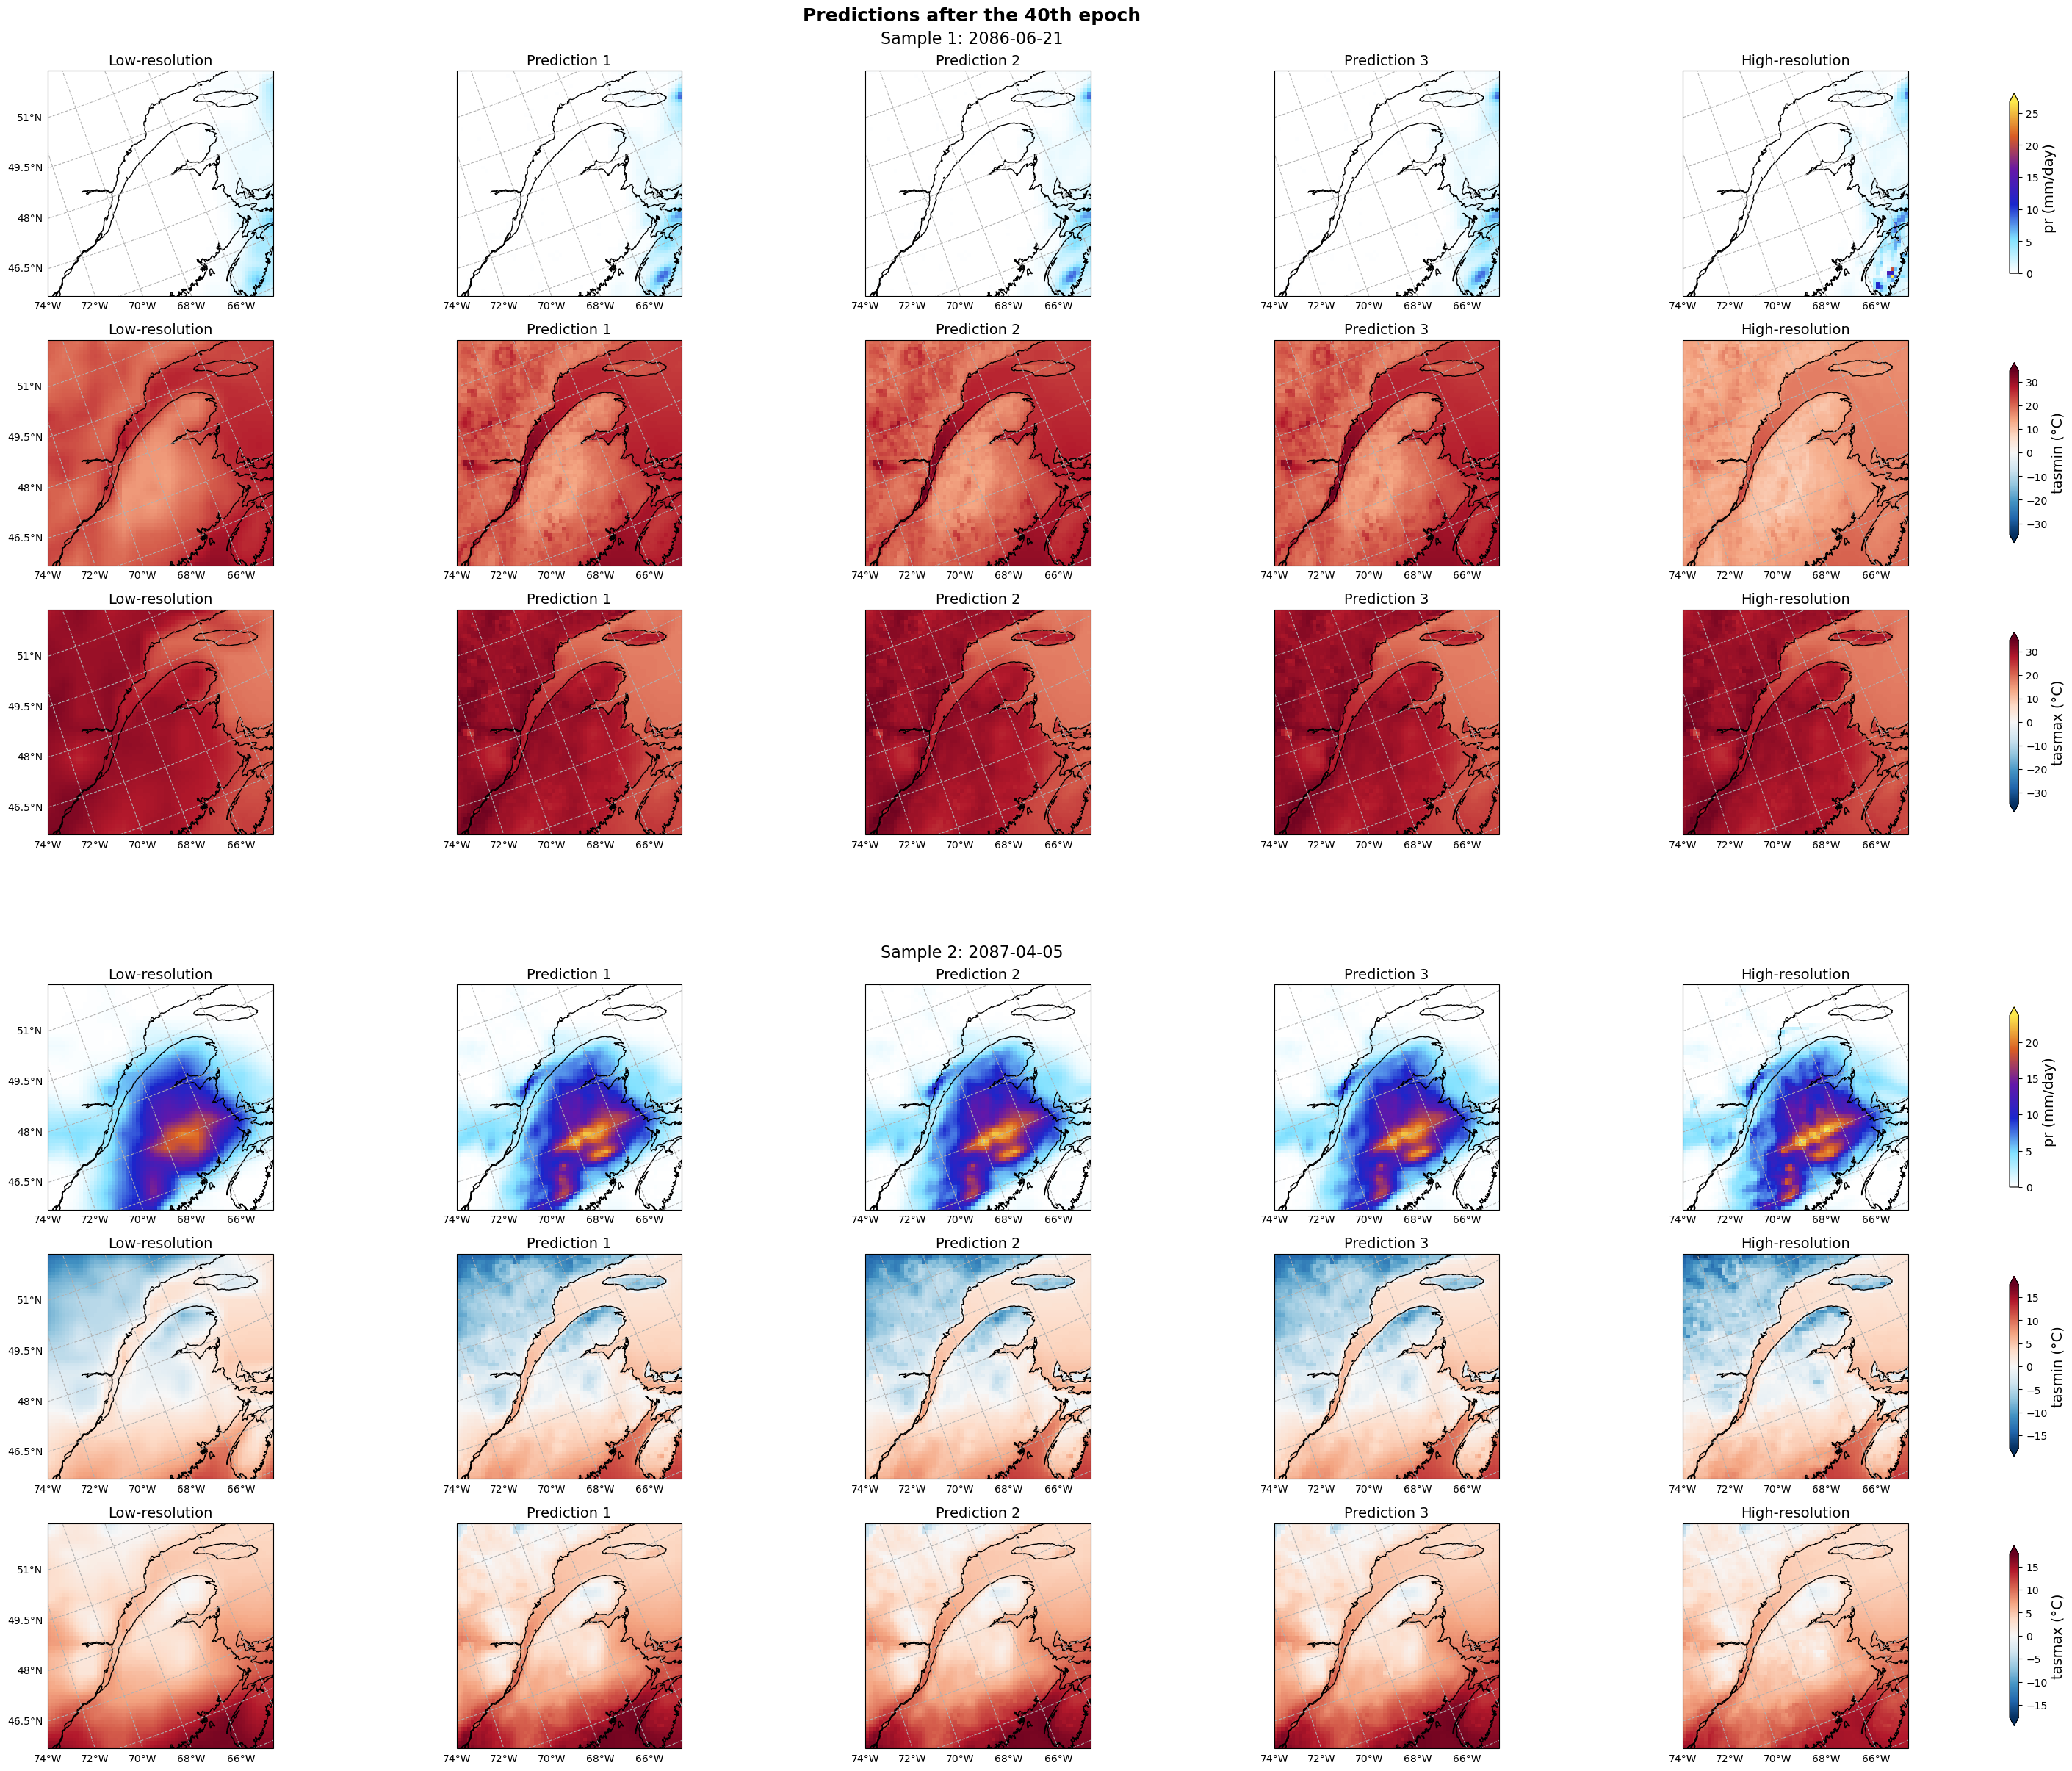

NameError: name 'fig' is not defined

In [1]:
import torch
import wandb
import matplotlib.pyplot as plt

import climex_utils as cu
import train_prob_unet_model as tm  # Use the adjusted training functions
from prob_unet import ProbabilisticUNet
from trainmodel import get_args

if __name__ == "__main__":
    # Importing all required arguments
    args = get_args()

    # Adjust arguments for testing
    args.years_train = range(1960, 2060)
    args.years_val = range(2060, 2080)
    args.years_test = range(2080, 2098)
    args.coords = [120, 184, 120, 184]
    args.resolution = (64, 64)
    args.variables = ['pr', 'tasmin', 'tasmax']
    args.num_epochs = 2
    args.batch_size = 8
    args.wandb = False


    # Initializing the Probabilistic UNet model
    probunet_model = ProbabilisticUNet(
        input_channels=len(args.variables),
        num_classes=len(args.variables),
        latent_dim=6,
        num_filters=[64,128,256,512]
    ).to(args.device)


    # Initializing the datasets
    dataset_train = cu.climex2torch(
        args.datadir,
        years=args.years_train,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=True
    )
    dataset_val = cu.climex2torch(
        args.datadir,
        years=args.years_val,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=False,
        trainset=dataset_train
    )
    dataset_test = cu.climex2torch(
        args.datadir,
        years=args.years_test,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=False,
        trainset=dataset_train
    )

    # Initializing the dataloaders
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4
    )
    dataloader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4
    )
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4
    )
    dataloader_test_random = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=2,
        shuffle=True,
        num_workers=4
    )

    # Initializing training objects
    optimizer = args.optimizer(params=probunet_model.parameters(), lr=args.lr)

    tr_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, args.num_epochs + 1):
        # Training for one epoch
        epoch_tr_loss = tm.train_probunet_step(
            model=probunet_model,
            dataloader=dataloader_train,
            optimizer=optimizer,
            epoch=epoch,
            num_epochs=args.num_epochs,
            accum=args.accum,
            wandb_active=args.wandb,
            device=args.device
        )
        tr_losses.append(epoch_tr_loss)

        # Evaluating the model on validation data
        epoch_val_loss = tm.eval_probunet_model(
            model=probunet_model,
            dataloader=dataloader_val,
            wandb_active=args.wandb,
            device=args.device
        )
        val_losses.append(epoch_val_loss)

        # Sampling from the model every 2 epochs
        if epoch % 40 == 0:
            samples, (fig, axs) = tm.sample_probunet_model(
                model=probunet_model,
                dataloader=dataloader_test_random,
                epoch=epoch,
                device=args.device
            )
            # Save sample plots 
            fig.savefig(f"./{args.plotdir}/epoch{epoch}.png", dpi=300)
            plt.close(fig)

    # Plotting the training and validation losses
    fig = plt.figure(figsize=(15, 10))
    plt.plot(tr_losses, lw=2, label='Training Loss')
    plt.plot(val_losses, lw=2, linestyle='dashed', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    fig.savefig(f"./{args.plotdir}/loss.png", dpi=300)
    plt.close(fig)


Generating train set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################

Generating test set
Imported all data files into xarray Dataset using lazy loading
Loaded dataset into memory

##########################################
############ PROCESSING DONE #############
##########################################



:: Evaluation ::: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 913/913 [00:18<00:00, 49.36it/s, Loss: 41939.0507]


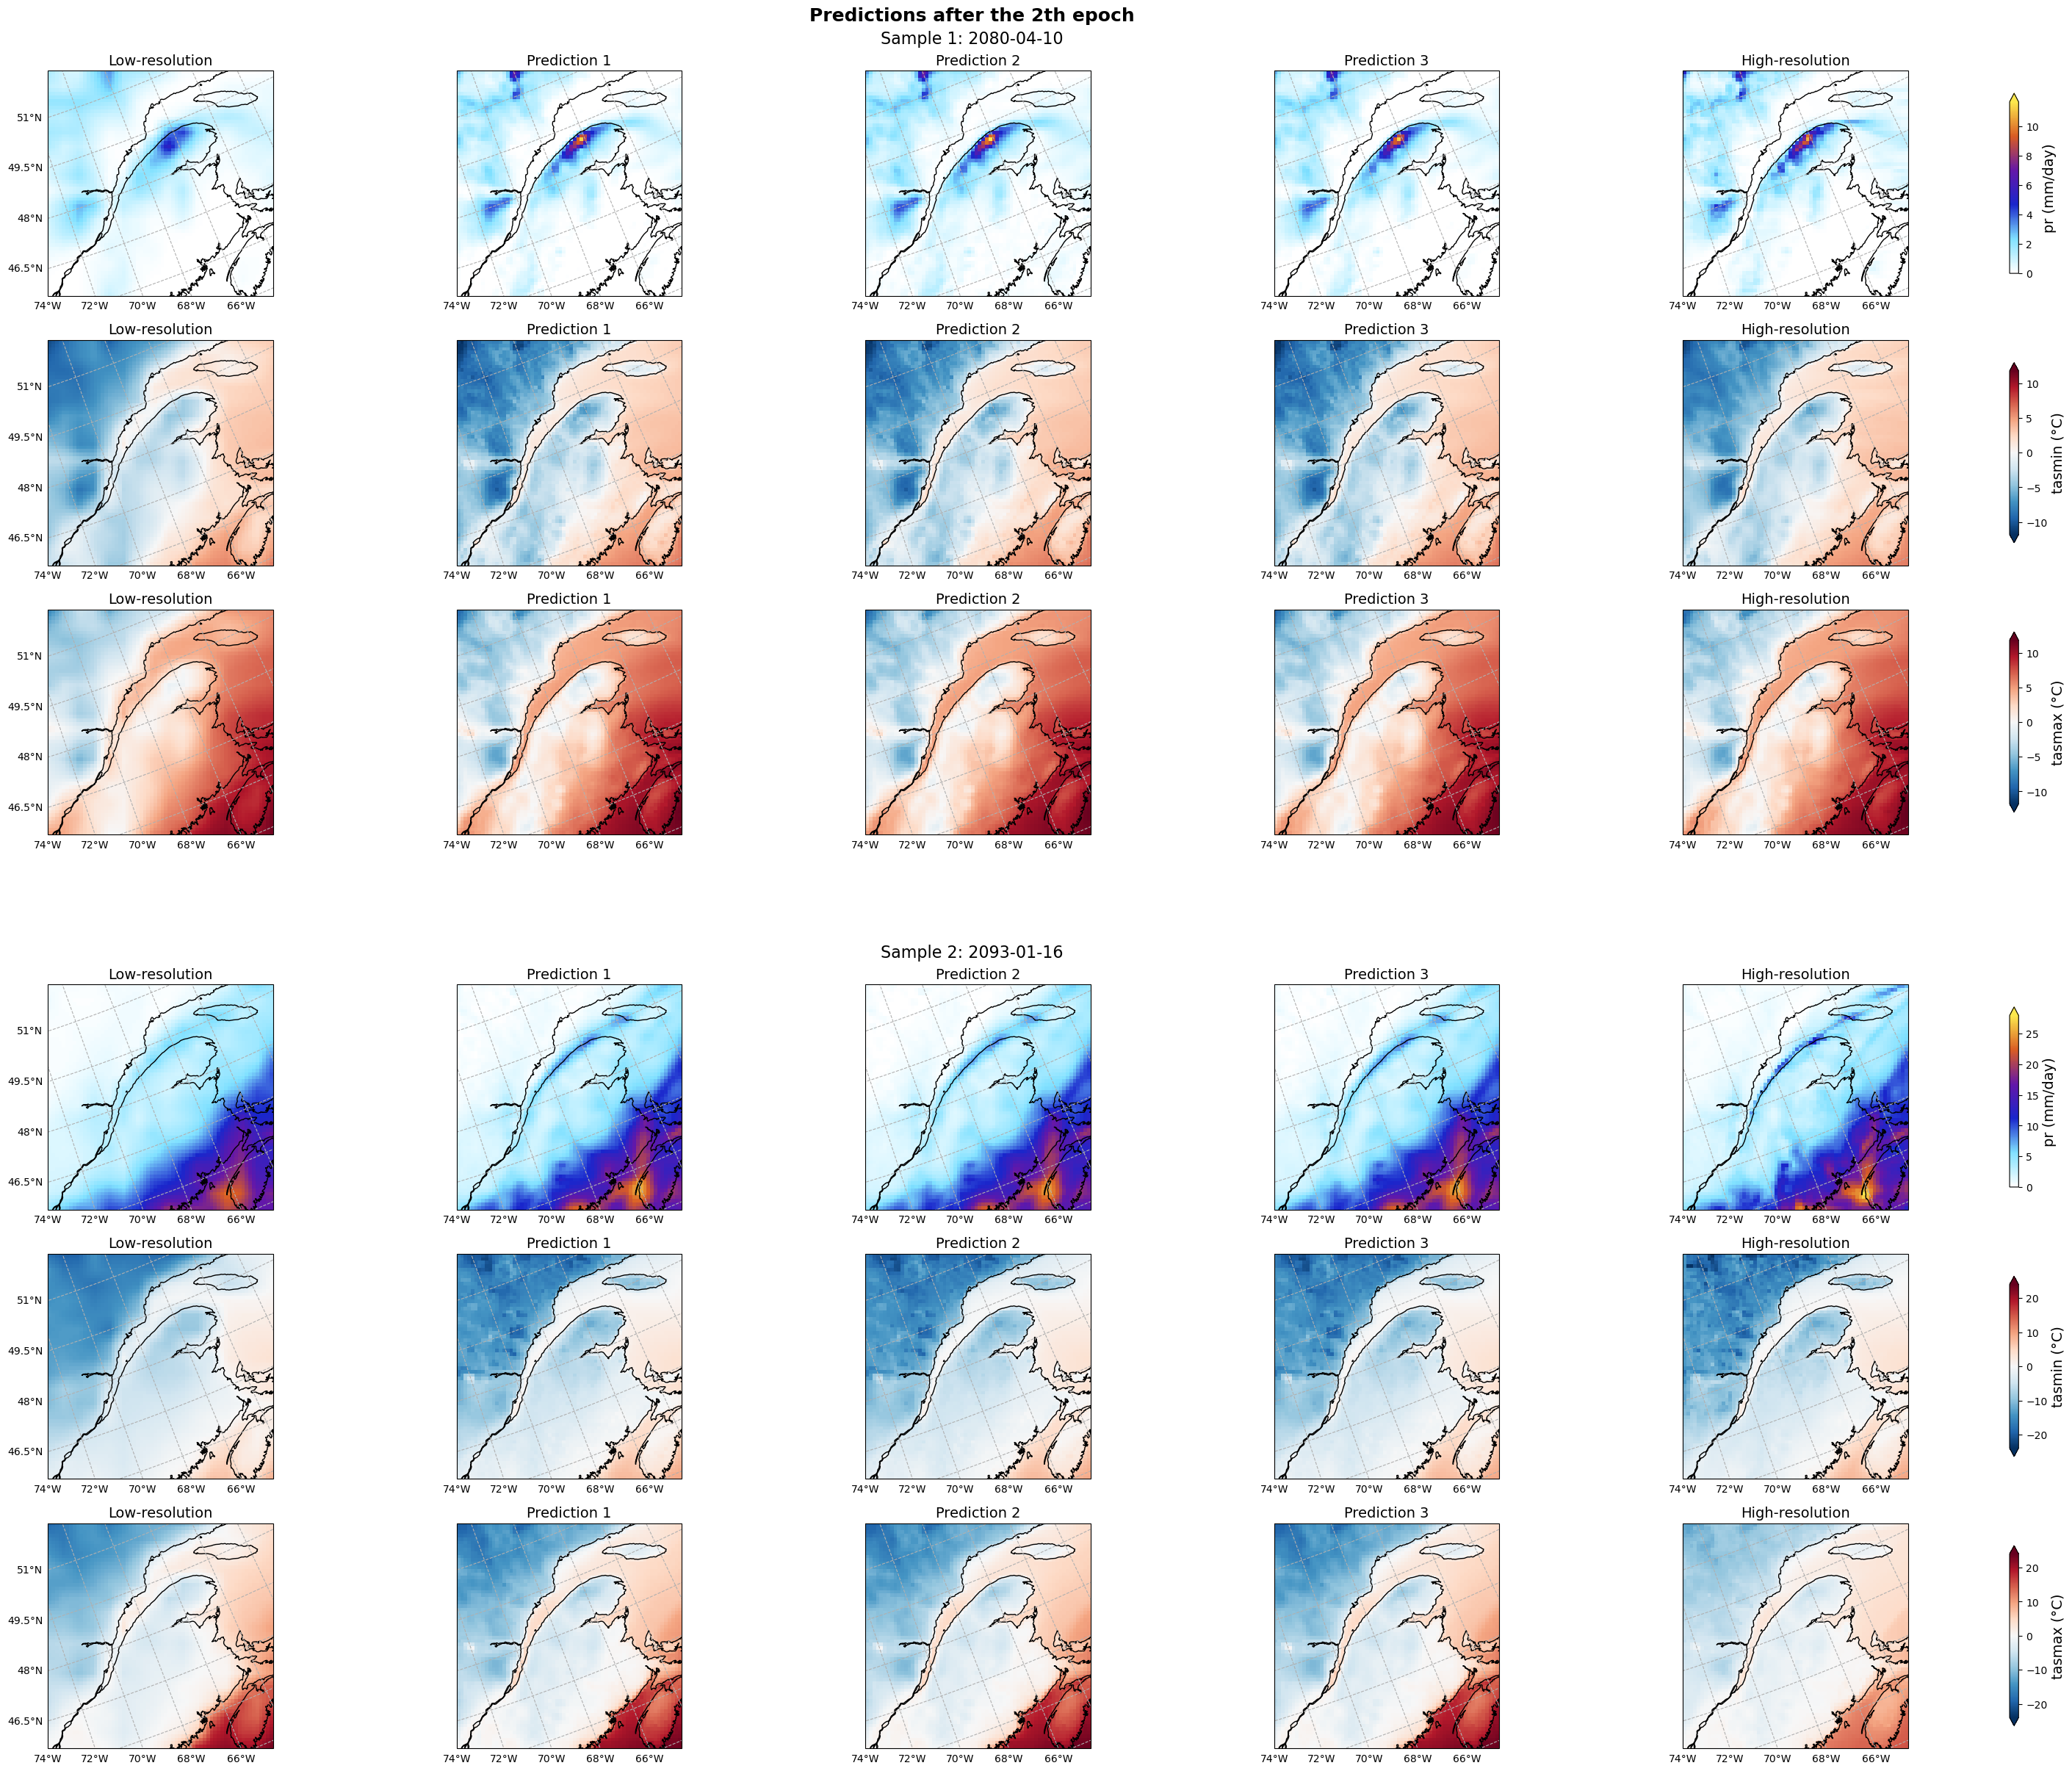

ValueError: too many values to unpack (expected 2)

In [2]:
import torch
import wandb
import matplotlib.pyplot as plt

import climex_utils as cu
import train_prob_unet_model as tm  # Use the adjusted training functions
from prob_unet import ProbabilisticUNet
from trainmodel import get_args

if __name__ == "__main__":
    # Importing all required arguments
    args = get_args()

    # Adjust arguments for testing
    args.years_train = range(1960, 2060)
    args.years_val = range(2060, 2080)
    args.years_test = range(2080, 2098)
    args.coords = [120, 184, 120, 184]
    args.resolution = (64, 64)
    args.variables = ['pr', 'tasmin', 'tasmax']
    args.num_epochs = 2
    args.batch_size = 8
    args.beta = 0.01
    args.wandb = False


    # Initializing the Probabilistic UNet model
    probunet_model = ProbabilisticUNet(
        input_channels=len(args.variables),
        num_classes=len(args.variables),
        latent_dim=6,
        num_filters=[64,128,256,512],
        beta=args.beta
    ).to(args.device)


    # Initializing the datasets
    dataset_train = cu.climex2torch(
        args.datadir,
        years=args.years_train,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=True
    )
    dataset_val = cu.climex2torch(
        args.datadir,
        years=args.years_val,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=False,
        trainset=dataset_train
    )
    dataset_test = cu.climex2torch(
        args.datadir,
        years=args.years_test,
        variables=args.variables,
        coords=args.coords,
        lowres_scale=args.lowres_scale,
        train=False,
        trainset=dataset_train
    )

    # Initializing the dataloaders
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4
    )
    dataloader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4
    )
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4
    )
    dataloader_test_random = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=2,
        shuffle=True,
        num_workers=4
    )

    # Initializing training objects
    optimizer = args.optimizer(params=probunet_model.parameters(), lr=args.lr)

    tr_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, args.num_epochs + 1):
        # Training for one epoch
        epoch_tr_loss = tm.train_probunet_step(
            model=probunet_model,
            dataloader=dataloader_train,
            optimizer=optimizer,
            epoch=epoch,
            num_epochs=args.num_epochs,
            accum=args.accum,
            wandb_active=args.wandb,
            device=args.device
        )
        tr_losses.append(epoch_tr_loss)

        # Evaluating the model on validation data
        epoch_val_loss = tm.eval_probunet_model(
            model=probunet_model,
            dataloader=dataloader_val,
            wandb_active=args.wandb,
            device=args.device
        )
        val_losses.append(epoch_val_loss)

        # Sampling from the model every 2 epochs
        if epoch % 2 == 0:
            samples, (fig, axs) = tm.sample_probunet_model(
                model=probunet_model,
                dataloader=dataloader_test_random,
                epoch=epoch,
                device=args.device
            )
            # Save sample plots 
            fig.savefig(f"./{args.plotdir}/epoch{epoch}.png", dpi=300)
            plt.close(fig)

    # Plotting the training and validation losses
    fig = plt.figure(figsize=(15, 10))
    plt.plot(tr_losses, lw=2, label='Training Loss')
    plt.plot(val_losses, lw=2, linestyle='dashed', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    fig.savefig(f"./{args.plotdir}/loss.png", dpi=300)
    plt.close(fig)
